Click [here]() to access the associated Medium article.

# Setup

In [2]:
!pip install -q polars matplotlib

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
import random
import string

import matplotlib.pyplot as plt

import polars as pl


SEED = 777  # for reproducibility
plt.style.use("ggplot_classic.mplstyle")  # a custom plot style

# Dataset

In [4]:
# Setting the seed for reproducibility
random.seed(SEED)

# Defining the size of our dataset
size = 1000000

# Creating a DataFrame
df = pl.DataFrame(
    {
        "age": [random.randint(20, 70) for _ in range(size)],
        "city": [
            random.choice(["New York", "London", "Berlin", "Tokyo"])
            for _ in range(size)
        ],
        "is_married": [random.choice([True, False]) for _ in range(size)],
        "bmi": [round(random.uniform(17.0, 27.0), 2) for _ in range(size)],
    }
)

## Inspecting the Dataset

In [5]:
df.shape

(1000000, 4)

In [6]:
df.head()

age,city,is_married,bmi
i64,str,bool,f64
34,"""New York""",false,17.62
48,"""Tokyo""",true,25.62
48,"""Tokyo""",false,18.25
43,"""London""",true,17.73
56,"""Berlin""",false,21.42


In [7]:
df.describe()

describe,age,city,is_married,bmi
str,f64,str,f64,f64
"""count""",1e6,"""1000000""",1e6,1e6
"""null_count""",0.0,"""0""",0.0,0.0
"""mean""",45.007378,null,0.498941,21.998514
"""std""",14.714038,null,0.499998,2.885383
"""min""",20.0,"""Berlin""",0.0,17.0
"""max""",70.0,"""Tokyo""",1.0,27.0
"""median""",45.0,null,0.0,22.0
"""25%""",32.0,null,null,19.5
"""75%""",58.0,null,null,24.5


# Data Cleaning

## Missing Values

In [8]:
# Create some missing data.
# Whenever 'age' is over 68, corresponding 'bmi' becomes 'null'
df = df.with_columns(
    pl.when(pl.col("age") > 68).then(None).otherwise(pl.col("bmi")).alias("bmi")
)

In [9]:
# Counting missing values
df.null_count()

age,city,is_married,bmi
u32,u32,u32,u32
0,0,0,39283


In [10]:
# Imputing missing values with the median of the column 'bmi'
df = df.with_columns(pl.col("bmi").fill_null(pl.median("bmi")))

# Counting missing values again
df.null_count()

age,city,is_married,bmi
u32,u32,u32,u32
0,0,0,0


## Type Casting

In [11]:
# Casting 'bmi' to integer (show only).
df.select(pl.col("bmi").cast(pl.Int32)).head()

bmi
i32
17
25
18
17
21


In [12]:
# Original 'bmi'
df.select(pl.col("bmi")).head()

bmi
f64
17.62
25.62
18.25
17.73
21.42


## Creating New Columns

In [13]:
# Create a new column 'age_in_months' (show only)
df.with_columns((pl.col("age") * 12).alias("age_in_months")).head()

age,city,is_married,bmi,age_in_months
i64,str,bool,f64,i64
34,"""New York""",false,17.62,408
48,"""Tokyo""",true,25.62,576
48,"""Tokyo""",false,18.25,576
43,"""London""",true,17.73,516
56,"""Berlin""",false,21.42,672


## Removing Duplicates

In [14]:
# Save only unique values in the dataset
df = df.unique()

# Data Visualization

In [15]:
# Sample 1000 rows from the dataset
sample_df = df.sample(1000)

## Histogram

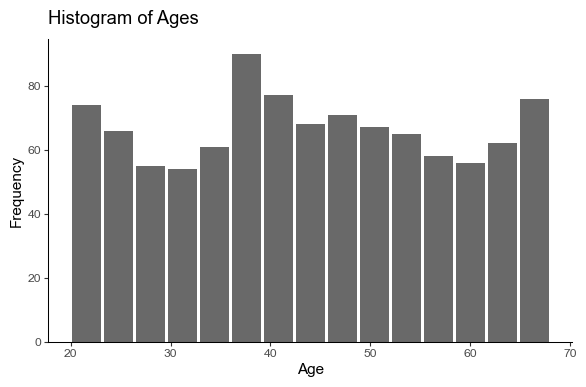

In [53]:
# Create a figure
plt.figure(figsize=(6, 4), layout="tight")

# Plot
plt.hist(sample_df["age"], bins=15, rwidth=0.9, color="dimgray")

# Add a title and axis labels
plt.title("Histogram of Ages")
plt.xlabel("Age")
plt.ylabel("Frequency")

# Save the plot
plt.savefig("histogram.png", dpi=100)

# Show the plot
plt.show()

## Box Plot

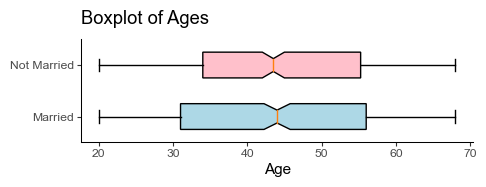

In [104]:
# Data
married = sample_df.filter(pl.col("is_married") == True)
not_married = sample_df.filter(pl.col("is_married") == False)

# Create a figure
plt.figure(figsize=(5, 2), layout="tight")

# Plot
bplot = plt.boxplot(
    [married["age"], not_married["age"]],
    notch=True,
    labels=["Married", "Not Married"],
    vert=False,
    widths=0.5,
    patch_artist=True,
)

bplot["boxes"][0].set_facecolor("lightblue")
bplot["boxes"][1].set_facecolor("pink")

# Add a title and axis labels
plt.title("Boxplot of Ages")
plt.xlabel("Age")

# Save the plot
plt.savefig("boxplot.png", dpi=100)

# Show the plot
plt.show()

## Scatter Plot

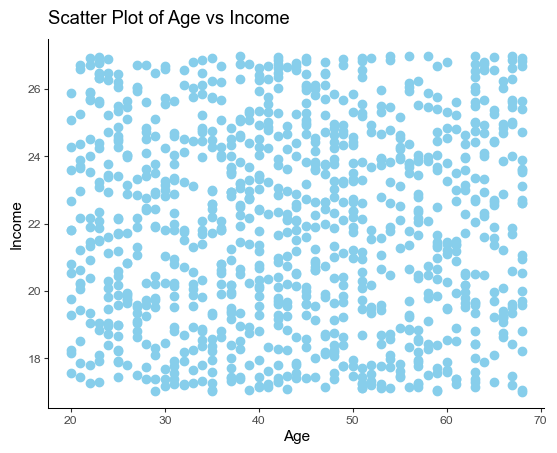

In [22]:
plt.scatter(sample_df["age"], sample_df["bmi"], color="skyblue")
plt.title("Scatter Plot of Age vs Income")
plt.xlabel("Age")
plt.ylabel("Income")
plt.show()

## Bar Chart

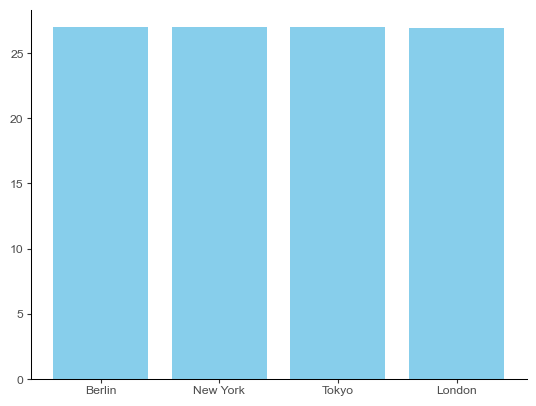

In [23]:
plt.bar(sample_df["city"], sample_df["bmi"], color="skyblue")
plt.show()

# Descriptive Statistics and Insights

## Mean, Median, and Standard Deviation

In [24]:
# Mean
mean_age = df["age"].mean()
print(f"Average age is {mean_age:.2f}")

# Median
median_age = df["age"].median()
print(f"Median age is {median_age}")

# Standard deviation
std_age = df["age"].std()
print(f"Standard deviation of age is {std_age:.2f}")

Average age is 44.01
Median age is 44.0
Standard deviation of age is 14.14


## Correlation

In [25]:
df.select(pl.corr("age", "bmi").alias("correlation"))

correlation
f64
0.000711


# Advanced EDA Techniques

## Grouping Data

In [26]:
df.groupby("city").agg(
    [
        pl.col("age").mean().alias("average_age"),
        pl.col("bmi").median().alias("median_bmi"),
    ]
)

city,average_age,median_bmi
str,f64,f64
"""Tokyo""",44.01207,22.0
"""New York""",44.017753,22.01
"""London""",44.001051,21.99
"""Berlin""",44.009009,22.01


## Apply Custom Functions

In [27]:
def age_group(age):
    if age < 30:
        return "Young"
    elif age < 60:
        return "Adult"
    else:
        return "Senior"


df.with_columns(pl.col("age").apply(age_group).alias("age_group")).head()

age,city,is_married,bmi,age_group
i64,str,bool,f64,str
48,"""Berlin""",false,17.74,"""Adult"""
59,"""London""",true,20.04,"""Adult"""
60,"""London""",true,20.96,"""Senior"""
52,"""Berlin""",false,21.51,"""Adult"""
22,"""London""",false,23.24,"""Young"""


## Pivot Tables

In [28]:
# Average 'bmi', by 'is_married' and 'city'
df.pivot(
    index="is_married",
    columns="city",
    values="bmi",
    aggregate_function="mean",
)

is_married,Berlin,London,New York,Tokyo
bool,f64,f64,f64,f64
false,22.003328,21.99395,22.009592,21.997339
true,22.004602,21.996581,22.004004,21.995983
